In [1]:
!pip install unrar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!unrar x '/content/drive/MyDrive/Weather Recognizer/dataset.rar'

Datele de ieșire de afișat au fost trunchiate la ultimele 5000 linii.
Extracting  train/frost/3902.jpg                                          34%  OK 
Extracting  train/frost/3903.jpg                                          34%  OK 
Extracting  train/frost/3904.jpg                                          34%  OK 
Extracting  train/frost/3905.jpg                                          34%  OK 
Extracting  train/frost/3906.jpg                                          34%  OK 
Extracting  train/frost/3907.jpg                                          34%  OK 
Extracting  train/frost/3908.jpg                                          34%  OK 
Extracting  train/frost/3909.jpg                                          34%  OK 
Extracting  train/frost/3910.jpg                                          34%  OK 
Extracting  train/frost/3911.jpg                                          34%  OK 
Extracting

In [3]:
%%writefile model_builder.py

import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes: int):
  
    """Creates an EfficientNetB2 model."""
   
    # Create model and transforms
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze layers
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )
    
    return model, transforms

Writing model_builder.py


In [4]:
%%writefile data_setup.py

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int):
  
  """Creates training and testing DataLoaders."""

  #Create Datasets
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  #Getting the class names
  class_names = train_data.classes

  #Create Dataloaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

Writing data_setup.py


In [5]:
%%writefile engine.py

from timeit import default_timer as timer 
from tqdm.auto import tqdm

import torch

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  
  """Train for a single epoch."""

  train_loss = 0
  train_acc = 0

  model.train()
    
  for batch, (X, y) in enumerate(dataloader):

    X = X.to(device)
    y = y.to(device)

    y_prediction = model(X)

    loss = loss_fn(y_prediction, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_prediction_class = torch.argmax(torch.softmax(y_prediction, dim=1), dim=1)
    train_acc += (y_prediction_class == y).sum().item()/len(y_prediction)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc


def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device):

  """Test for a single epoch."""

  test_loss = 0
  test_acc = 0

  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)

      y_prediction = model(X)

      loss = loss_fn(y_prediction, y)
      test_loss += loss.item()

      y_prediction_class = y_prediction.argmax(dim=1)
      test_acc += ((y_prediction_class == y).sum().item()/len(y_prediction))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc


def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device):
  
  """Train and test a model. It returns a dictionary with the results."""

  start_time = timer()
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}")
    
     
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  end_time = timer()
  total_time = end_time - start_time
  print(f'Total time: {total_time:.2f} seconds')

  return results

Writing engine.py


In [35]:
%%writefile utils.py

import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path

import torch
from torchvision import datasets

def plot_random_images(image_directory: str):

  """Plot random images from the dataset."""

  dir = Path(image_directory)
  train_data = datasets.ImageFolder(dir)
  class_names = train_data.classes
  ROWS = 3
  COLS = 3
  fig = plt.figure(figsize=(9,9))
  for i in range(ROWS*COLS):
    img_idx = torch.randint(1, len(train_data), size=[1]).item()
    img, img_label = train_data[img_idx]
    fig.add_subplot(ROWS, COLS, i+1)
    plt.imshow(img)
    plt.title(class_names[img_label])
    plt.axis(False)


def plot_loss_curve(model_results: dict):

  """Plot the loss curve of a model using a dictionary with the results."""

  plt.figure(figsize=(12,5))

  model_df = pd.DataFrame(model_results)
  epochs = range(len(model_results['train_loss']))

  plt.subplot(1,2,1)
  plt.plot(epochs, model_df['train_loss'], label='Train')
  plt.plot(epochs, model_df['test_loss'], label='Test')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, model_df['train_acc'], label='Train')
  plt.plot(epochs, model_df['test_acc'], label='Test')
  plt.title('Acc')
  plt.xlabel('Epochs')
  plt.legend()


def save_model(model: torch.nn.Module,
               model_name: str):
  
  """Save PyTorch model."""

  # Create dir
  target_dir_path = Path('models')
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  model_save_path = target_dir_path / model_name

  # Save the model
  print(f"[INFO] Model saved to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

Overwriting utils.py


In [7]:
%%writefile train.py

import os
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import data_setup, engine, model_builder, utils

NUM_EPOCHS = 1
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
LEARNING_RATE = 3e-4

# Directories
train_dir = Path('/content/train') 
test_dir = Path('/content/test')

NUM_CLASSES = len(next(os.walk(train_dir))[1])

# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model
model, transform = model_builder.create_effnetb2_model(num_classes=NUM_CLASSES)
model.to(device)

# Dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, 
                                                                               test_dir=test_dir, 
                                                                               transform=transform, 
                                                                               batch_size=BATCH_SIZE, 
                                                                               num_workers=NUM_WORKERS)

# Train model
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       epochs=NUM_EPOCHS,
                       device=device)
                       
# Save model
utils.save_model(model=model,
                 model_name="model_0.pth")

Writing train.py


**Libraries**

In [8]:
import os
import torch
import random
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import data_setup, engine, model_builder, utils

**Data setup**

In [16]:
NUM_EPOCHS = 50
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
LEARNING_RATE = 3e-4

# Directories
train_dir = Path('/content/train') 
test_dir = Path('/content/test')

NUM_CLASSES = len(next(os.walk(train_dir))[1])

# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}.')

Device: cuda.


**Create model**

In [11]:
model, transform = model_builder.create_effnetb2_model(num_classes=NUM_CLASSES)
model.to(device)
next(model.parameters()).is_cuda

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

True

**Model summary**

In [12]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

summary(model=model, 
        input_size=(32, 3, 288, 288),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=22) 

[INFO] Couldn't find torchinfo... installing it.


Layer (type:depth-idx)                                  Input Shape            Output Shape           Param #                Trainable
EfficientNet                                            [32, 3, 288, 288]      [32, 12]               --                     Partial
├─Sequential: 1-1                                       [32, 3, 288, 288]      [32, 1408, 9, 9]       --                     False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 288, 288]      [32, 32, 144, 144]     --                     False
│    │    └─Conv2d: 3-1                                 [32, 3, 288, 288]      [32, 32, 144, 144]     (864)                  False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 144, 144]     [32, 32, 144, 144]     (64)                   False
│    │    └─SiLU: 3-3                                   [32, 32, 144, 144]     [32, 32, 144, 144]     --                     --
│    └─Sequential: 2-2                                  [32, 32, 144, 144]     [

**Create dataloaders**

In [13]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, 
                                                                               test_dir=test_dir, 
                                                                               transform=transform, 
                                                                               batch_size=BATCH_SIZE, 
                                                                               num_workers=NUM_WORKERS)

**Visualize our data**

In [14]:
print(f'[INFO] Number of classes: {len(class_names)}')
print(f"[INFO] Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"[INFO] Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

[INFO] Number of classes: 12
[INFO] Length of train dataloader: 170 batches of 32
[INFO] Length of test dataloader: 42 batches of 32


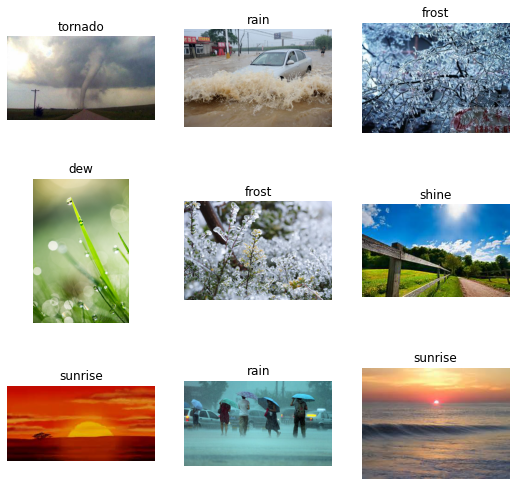

In [15]:
utils.plot_random_images('/content/train')

**Train the model**

In [17]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       epochs=NUM_EPOCHS,
                       device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7208 | train_acc: 0.5542 | test_loss: 1.2548 | test_acc: 0.8044
Epoch: 2 | train_loss: 0.9935 | train_acc: 0.8043 | test_loss: 0.8606 | test_acc: 0.8418
Epoch: 3 | train_loss: 0.7394 | train_acc: 0.8365 | test_loss: 0.6757 | test_acc: 0.8619
Epoch: 4 | train_loss: 0.6014 | train_acc: 0.8621 | test_loss: 0.5888 | test_acc: 0.8709
Epoch: 5 | train_loss: 0.5322 | train_acc: 0.8693 | test_loss: 0.5266 | test_acc: 0.8828
Epoch: 6 | train_loss: 0.4908 | train_acc: 0.8700 | test_loss: 0.4814 | test_acc: 0.8867
Epoch: 7 | train_loss: 0.4565 | train_acc: 0.8799 | test_loss: 0.4422 | test_acc: 0.8956
Epoch: 8 | train_loss: 0.4356 | train_acc: 0.8821 | test_loss: 0.4320 | test_acc: 0.8981
Epoch: 9 | train_loss: 0.4074 | train_acc: 0.8876 | test_loss: 0.4094 | test_acc: 0.8988
Epoch: 10 | train_loss: 0.3893 | train_acc: 0.8892 | test_loss: 0.3965 | test_acc: 0.8959
Epoch: 11 | train_loss: 0.3750 | train_acc: 0.8904 | test_loss: 0.3809 | test_acc: 0.8988
Epoch: 12 | train_l

**Plot a loss curve**

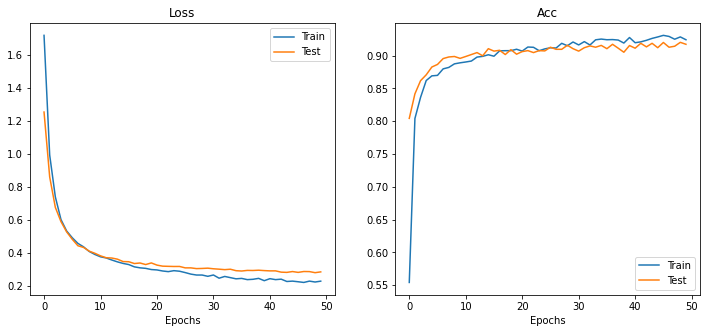

In [18]:
utils.plot_loss_curve(model_results=results)

**Save the model**

In [19]:
utils.save_model(model=model,
                 model_name="model_v3.pth")

[INFO] Model saved to: models/model_v3.pth


**Import gradio**

```
Gradio app structure

demos/
└── weather_image_recognition/
    ├── model.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

In [20]:
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")

     |████████████████████████████████| 11.6 MB 21.0 MB/s 
     |████████████████████████████████| 54 kB 3.8 MB/s 
     |████████████████████████████████| 56 kB 5.3 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 106 kB 72.3 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 278 kB 68.9 MB/s 
     |████████████████████████████████| 213 kB 69.4 MB/s 
     |████████████████████████████████| 2.3 MB 58.7 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 64 kB 2.8 MB/s 
     |████████████████████████████████| 80 kB 10.5 MB/s 
     |████████████████████████████████| 68 kB 7.9 MB/s 
     |████████████████████████████████| 68 kB 5.7 MB/s 
     |████████████████████████████████| 68 kB 7.6 MB/s 
     |████████████████████████████████| 68 kB 7.9 MB/s 
     |████████████████████████████████| 46 kB 2.9 MB/s 
     |██████████████████████████████

**Create predict function**

In [21]:
def predict(img):
 
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = transform(img).unsqueeze(0)
    
    model.eval()
    with torch.inference_mode():
        
        predictions = torch.softmax(model(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio)
    pred_labels_and_probs = {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}
    
    pred_time = round(timer() - start_time, 4)
    
    return pred_labels_and_probs, pred_time

**Example list**

In [42]:
test_images_path = '/content/drive/MyDrive/Weather Recognizer/examples'
test_data_paths = list(Path(test_images_path).glob("*.jpg"))

example_list = [str(filepath) for filepath in test_data_paths]
example_list

['/content/drive/MyDrive/Weather Recognizer/examples/cloudy.jpg',
 '/content/drive/MyDrive/Weather Recognizer/examples/tornado.jpg',
 '/content/drive/MyDrive/Weather Recognizer/examples/sunrise.jpg',
 '/content/drive/MyDrive/Weather Recognizer/examples/snow.jpg',
 '/content/drive/MyDrive/Weather Recognizer/examples/lightning.jpg',
 '/content/drive/MyDrive/Weather Recognizer/examples/shine.jpg',
 '/content/drive/MyDrive/Weather Recognizer/examples/rain.jpg',
 '/content/drive/MyDrive/Weather Recognizer/examples/dew.jpg',
 '/content/drive/MyDrive/Weather Recognizer/examples/fog.jpg',
 '/content/drive/MyDrive/Weather Recognizer/examples/hail.jpg',
 '/content/drive/MyDrive/Weather Recognizer/examples/frost.jpg']

**Interface**

In [39]:
title = "Weather image recognition ⛅❄☔"
description = "Classifies the weather from an image, able to recognize 12 types of weather."

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=1, label="Predictions"), 
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description)


demo.launch(debug=False,
            share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://5212443feeb1f7d5.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


**Create directories**

In [43]:
# Create demos dir
weather_image_recognition_path = Path("demos/weather_image_recognition/")

if weather_image_recognition_path.exists():
    shutil.rmtree(weather_image_recognition_path)
    weather_image_recognition_path.mkdir(parents=True, 
                                    exist_ok=True) 
else:
    weather_image_recognition_path.mkdir(parents=True, 
                                         exist_ok=True)
    
# Create examples dir
examples_path = weather_image_recognition_path / "examples"
examples_path.mkdir(parents=True, exist_ok=True)

weather_examples = [Path(path) for path in example_list]

for example in weather_examples:
    destination = examples_path / example.name
    shutil.copy2(src=example, dst=destination)

# Get example filepaths in a list of lists (required for gradio)
example_list = [["examples/" + example] for example in os.listdir(examples_path)]
example_list

[['examples/shine.jpg'],
 ['examples/fog.jpg'],
 ['examples/frost.jpg'],
 ['examples/tornado.jpg'],
 ['examples/sunrise.jpg'],
 ['examples/rain.jpg'],
 ['examples/lightning.jpg'],
 ['examples/cloudy.jpg'],
 ['examples/hail.jpg'],
 ['examples/snow.jpg'],
 ['examples/dew.jpg']]

**Moving the model**

In [27]:
# Src path
model_path = "models/model_v3.pth"

# Destination path
destination_path = weather_image_recognition_path / model_path.split("/")[1]

# Move the model
shutil.move(src=model_path, 
            dst=destination_path)

PosixPath('demos/weather_image_recognition/model_v3.pth')

**Create the model script**

In [28]:
# Move the model_builder script to demos directory

source = '/content/model_builder.py'
target = '/content/demos/model.py'
shutil.copy(source, target)

'/content/demos/model.py'

**Create class_names.txt**

In [30]:
with open("/content/demos/weather_image_recognition/class_names.txt", 'w') as f:
  f.write("\n".join(class_names))

**Create the app script**

In [45]:
%%writefile demos/weather_image_recognition/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer

# Setup class names
with open("class_names.txt", 'r') as f:
  classes = [name.strip() for name in f]

# Model and transforms
model, transform = create_effnetb2_model(
    num_classes=len(classes)
)

model.load_state_dict(
    torch.load(
        f="model_v3.pth",
        map_location=torch.device("cpu")
    )
)

# Predict function
def predict(img):
 
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = transform(img).unsqueeze(0)
    
    model.eval()
    with torch.inference_mode():
        
        predictions = torch.softmax(model(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio)
    pred_labels_and_probs = {classes[i]: float(predictions[0][i]) for i in range(len(classes))}
    
    pred_time = round(timer() - start_time, 4)
    
    return pred_labels_and_probs, pred_time

example_list = [["examples/" + example] for example in os.listdir("examples")]

# Gradio interface
title = "Weather image recognition ⛅❄☔"
description = "Classifies the weather from an image, able to recognize 12 types of weather."

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=1, label="Predictions"), 
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description)


demo.launch(debug=False,
            share=False)

Overwriting demos/weather_image_recognition/app.py


**Create req.txt**

In [33]:
%%writefile demos/weather_image_recognition/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/weather_image_recognition/requirements.txt


**Download the files**

In [34]:
!cd demos/weather_image_recognition && zip -r ../weather_image_recognition.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

try:
    from google.colab import files
    files.download("demos/weather_image_recognition.zip")
except:
    print("[INFO] Not running in Google Colab") 

  adding: app.py (deflated 54%)
  adding: class_names.txt (deflated 19%)
  adding: examples/ (stored 0%)
  adding: examples/2902.jpg (deflated 2%)
  adding: examples/1825.jpg (deflated 0%)
  adding: examples/sunrise183.jpg (deflated 1%)
  adding: model_v3.pth (deflated 8%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>